In [1]:
!pip install rembg onnxruntime opencv-contrib-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 800.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.5 MB/s eta 0:00:00


In [2]:
from rembg import remove
from PIL import Image
import io

input_path = '/content/p3.jpg'
output_path = 'p3_nobg.png'

with open(input_path, 'rb') as i:
    input_data = i.read()
    output_data = remove(input_data)

with open(output_path, 'wb') as o:
    o.write(output_data)

print("Background removed successfully!")


100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 164GB/s]


Background removed successfully!


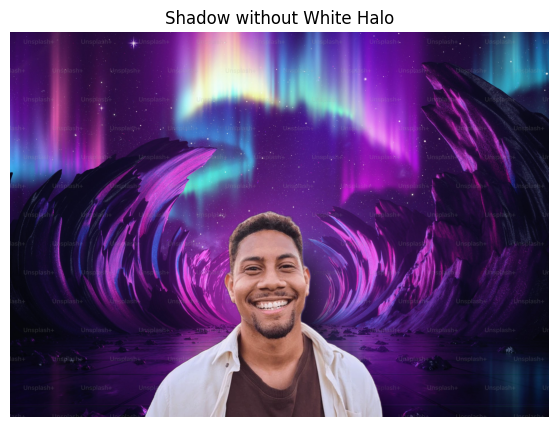

In [3]:
from PIL import Image, ImageFilter, ImageOps, ImageEnhance
import matplotlib.pyplot as plt

# Load images
bg = Image.open("bg2.jpg").convert("RGBA")
person = Image.open("p3_nobg.png").convert("RGBA")

# Resize person
bg_width, bg_height = bg.size
p_width, p_height = person.size
target_h = int(bg_height * 0.6)
scale = target_h / p_height
p_resized = person.resize((int(p_width * scale), target_h), Image.LANCZOS)

# Brightness correction
enhancer = ImageEnhance.Brightness(p_resized)
p_resized = enhancer.enhance(0.98)

# Extract alpha and make shadow
alpha = p_resized.split()[3]
shadow = Image.new("RGBA", p_resized.size, (0, 0, 0, 150))
shadow.putalpha(alpha)
blur_radius = int(p_resized.height * 0.1)
shadow = shadow.filter(ImageFilter.GaussianBlur(blur_radius))

# Offsets
offset_x = int(p_resized.width * 0.08)
offset_y = int(p_resized.height * 0.08)

# Create a temporary transparent canvas for shadow and person
temp_layer = Image.new("RGBA", bg.size, (0, 0, 0, 0))
px = (bg_width - p_resized.width) // 2
py = bg_height - p_resized.height

# Paste shadow and person onto the transparent canvas
temp_layer.paste(shadow, (px + offset_x, py + offset_y), shadow)
temp_layer.paste(p_resized, (px, py), p_resized)

# Use alpha_composite for proper blending
composite = Image.alpha_composite(bg, temp_layer)

# Save and display
composite.save("composite_clean_shadow.png")
plt.figure(figsize=(10, 5))
plt.imshow(composite)
plt.axis('off')
plt.title("Shadow without White Halo")
plt.show()


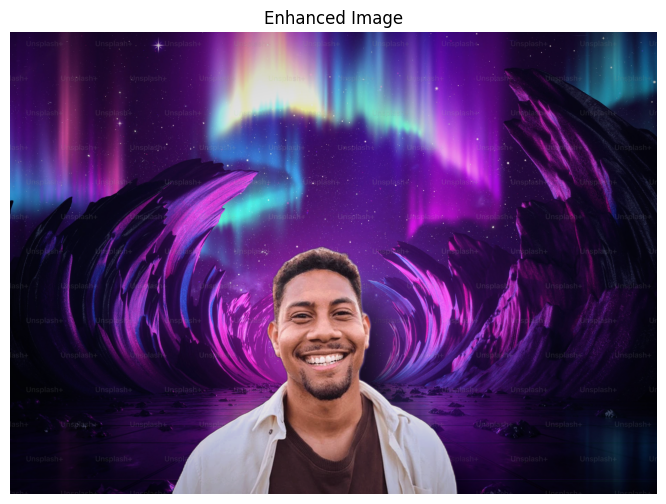

In [13]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt

def adjust_image(image_path):
    # === Load Image ===
    image = Image.open(image_path).convert("RGB")
    img = np.array(image)

    # === Exposure (simulate by brightness) ===
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(1.1)  # 1.0 = original

    # === Highlights & Shadows (simulate via gamma) ===
    def adjust_highlight_shadow(img, gamma=0.5):
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
        return cv2.LUT(img, table)

    img = np.array(image)
    img = adjust_highlight_shadow(img, gamma=0.9)  # lower gamma brightens shadows

    # === Contrast ===
    image = Image.fromarray(img)
    image = ImageEnhance.Contrast(image).enhance(1.0)

    # === Brightness ===
    image = ImageEnhance.Brightness(image).enhance(1.05)


    # === Saturation ===
    image = Image.fromarray(img)
    image = ImageEnhance.Color(image).enhance(1.3)


    # === Sharpness ===
    image = Image.fromarray(img)
    image = ImageEnhance.Sharpness(image).enhance(1.5)

    # === Definition (edge enhancement) ===
    image = image.filter(ImageFilter.EDGE_ENHANCE_MORE)


    # === Vignette Effect ===
    # === Vignette Effect (subtle) ===
    rows, cols = img.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols, cols / 2)
    kernel_y = cv2.getGaussianKernel(rows, rows / 2)
    kernel = kernel_y * kernel_x.T
    mask = kernel / np.max(kernel)  # normalize to 0-1
    mask = 0.5 + 0.5 * mask  # scale to range 0.5–1.0 for softer effect

    vignette = np.zeros_like(img, dtype=np.float32)
    for i in range(3):
        vignette[..., i] = img[..., i] * mask

    vignette = np.clip(vignette, 0, 255).astype(np.uint8)


    # === Show Result ===
    plt.figure(figsize=(12, 6))
    plt.imshow(vignette)
    plt.axis('off')
    plt.title('Enhanced Image')
    plt.show()

    # === Save Output ===
    Image.fromarray(vignette).save("adjusted_output.jpg")

# === Run ===
adjust_image("/content/composite_clean_shadow.png")


Background removed successfully.


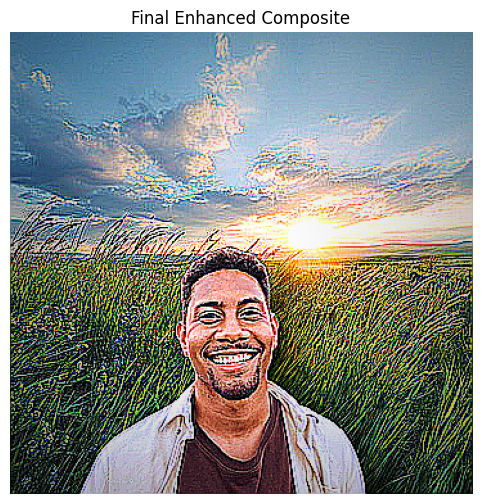

In [29]:
# === Step 1: Remove background from person ===
from rembg import remove
from PIL import Image, ImageEnhance, ImageFilter
import matplotlib.pyplot as plt
import numpy as np
import cv2
import io

person_input_path = "p3.jpg"
bg_path = "bg.jpg"

with open(person_input_path, 'rb') as f:
    input_data = f.read()
    output_data = remove(input_data)

# Save or directly use the output
person_no_bg = Image.open(io.BytesIO(output_data)).convert("RGBA")
person_no_bg.save("p3_nobg.png")  # optional save

print("Background removed successfully.")

# === Step 2: Load background and person ===
bg = Image.open(bg_path).convert("RGBA")
person = person_no_bg

# === Step 3: Resize person ===
bg_width, bg_height = bg.size
p_width, p_height = person.size
target_h = int(bg_height * 0.6)
scale = target_h / p_height
person_resized = person.resize((int(p_width * scale), target_h), Image.LANCZOS)

# === Step 4: Brightness correction (optional) ===
enhancer = ImageEnhance.Brightness(person_resized)
person_resized = enhancer.enhance(0.98)

# === Step 5: Create shadow using alpha channel ===
alpha = person_resized.split()[3]
shadow = Image.new("RGBA", person_resized.size, (0, 0, 0, 150))
shadow.putalpha(alpha)
blur_radius = int(person_resized.height * 0.1)
shadow = shadow.filter(ImageFilter.GaussianBlur(blur_radius))

# === Step 6: Compute positioning offsets ===
offset_x = int(person_resized.width * 0.08)
offset_y = int(person_resized.height * 0.08)
temp_layer = Image.new("RGBA", bg.size, (0, 0, 0, 0))

px = (bg_width - person_resized.width) // 2
py = bg_height - person_resized.height

temp_layer.paste(shadow, (px + offset_x, py + offset_y), shadow)
temp_layer.paste(person_resized, (px, py), person_resized)

# === Step 7: Merge background and composite ===
composite = Image.alpha_composite(bg, temp_layer)

# === Step 8: Enhance the composite ===
image = composite.convert("RGB")
img = np.array(image)

# Exposure (brightness)
image = ImageEnhance.Brightness(image).enhance(1.1)

# Highlights & shadows using gamma
def adjust_gamma(img, gamma=0.9):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(img, table)

img = np.array(image)
img = adjust_gamma(img, gamma=0.9)
image = Image.fromarray(img)

# Contrast
image = ImageEnhance.Contrast(image).enhance(1.0)

# Brightness again
image = ImageEnhance.Brightness(image).enhance(1.05)

# Saturation
image = ImageEnhance.Color(image).enhance(1.3)

# Sharpness
image = ImageEnhance.Sharpness(image).enhance(1.5)

# Definition
image = image.filter(ImageFilter.EDGE_ENHANCE_MORE)

# === Step 9: Apply vignette ===
img = np.array(image)
rows, cols = img.shape[:2]
kernel_x = cv2.getGaussianKernel(cols, cols / 2)
kernel_y = cv2.getGaussianKernel(rows, rows / 2)
kernel = kernel_y * kernel_x.T
mask = kernel / np.max(kernel)
mask = 0.5 + 0.5 * mask

vignette = np.zeros_like(img, dtype=np.float32)
for i in range(3):
    vignette[..., i] = img[..., i] * mask

vignette = np.clip(vignette, 0, 255).astype(np.uint8)

# === Step 10: Show and save ===
final_image = Image.fromarray(vignette)
final_image.save("final_output.jpg")

plt.figure(figsize=(12, 6))
plt.imshow(final_image)
plt.axis('off')
plt.title("Final Enhanced Composite")
plt.show()


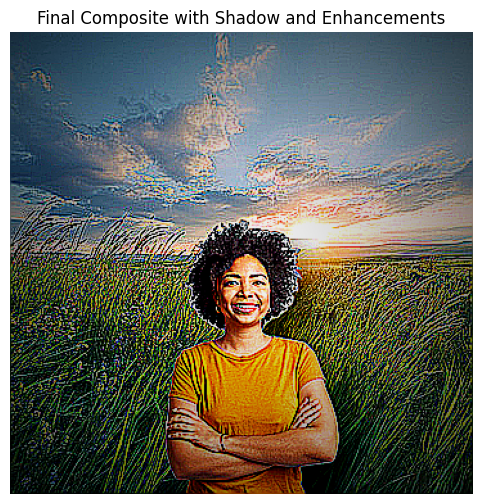

In [30]:
from rembg import remove
from PIL import Image, ImageFilter, ImageEnhance, ImageOps
import matplotlib.pyplot as plt
import numpy as np
import cv2
import io

def composite_with_shadow_and_enhance(person_path, bg_path, output_path="final_output.jpg"):
    # === Step 1: Background Removal ===
    with open(person_path, 'rb') as i:
        input_data = i.read()
        output_data = remove(input_data)

    person = Image.open(io.BytesIO(output_data)).convert("RGBA")

    # === Step 2: Load Background ===
    bg = Image.open(bg_path).convert("RGBA")
    bg_width, bg_height = bg.size

    # === Step 3: Resize Person ===
    p_width, p_height = person.size
    target_h = int(bg_height * 0.6)
    scale = target_h / p_height
    person = person.resize((int(p_width * scale), target_h), Image.LANCZOS)

    # === Step 4: Brightness Adjustment ===
    person = ImageEnhance.Brightness(person).enhance(0.98)

    # === Step 5: Create Shadow ===
    alpha = person.split()[3]
    shadow = Image.new("RGBA", person.size, (0, 0, 0, 150))
    shadow.putalpha(alpha)
    blur_radius = int(person.height * 0.1)
    shadow = shadow.filter(ImageFilter.GaussianBlur(blur_radius))

    # === Step 6: Paste Shadow and Person ===
    offset_x = int(person.width * 0.08)
    offset_y = int(person.height * 0.08)
    px = (bg_width - person.width) // 2
    py = bg_height - person.height

    temp_layer = Image.new("RGBA", bg.size, (0, 0, 0, 0))
    temp_layer.paste(shadow, (px + offset_x, py + offset_y), shadow)
    temp_layer.paste(person, (px, py), person)

    # === Step 7: Composite Image ===
    composite = Image.alpha_composite(bg, temp_layer)

    # === Step 8: Convert for Enhancement ===
    comp_rgb = composite.convert("RGB")
    img_np = np.array(comp_rgb)

    # === Step 9: Adjust Gamma (simulate highlight/shadow) ===
    def adjust_gamma(img, gamma=0.9):
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
        return cv2.LUT(img, table)

    img_np = adjust_gamma(img_np)

    # === Step 10: Enhance Contrast, Brightness, Saturation, Sharpness ===
    img_pil = Image.fromarray(img_np)
    img_pil = ImageEnhance.Contrast(img_pil).enhance(1.1)
    img_pil = ImageEnhance.Brightness(img_pil).enhance(1.05)
    img_pil = ImageEnhance.Color(img_pil).enhance(1.3)
    img_pil = ImageEnhance.Sharpness(img_pil).enhance(1.5)
    img_pil = img_pil.filter(ImageFilter.EDGE_ENHANCE_MORE)

    # === Step 11: Vignette Effect ===
    img_np = np.array(img_pil)
    rows, cols = img_np.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols, cols / 2)
    kernel_y = cv2.getGaussianKernel(rows, rows / 2)
    kernel = kernel_y * kernel_x.T
    mask = 255 * kernel / np.linalg.norm(kernel)
    vignette = np.zeros_like(img_np)
    for i in range(3):
        vignette[..., i] = img_np[..., i] * mask
    vignette = np.clip(vignette, 0, 255).astype(np.uint8)

    # === Step 12: Save & Show Final Output ===
    final_image = Image.fromarray(vignette)
    final_image.save(output_path)
    plt.figure(figsize=(12, 6))
    plt.imshow(final_image)
    plt.axis('off')
    plt.title("Final Composite with Shadow and Enhancements")
    plt.show()

# === Run Script ===
composite_with_shadow_and_enhance("p1.jpg", "bg.jpg")


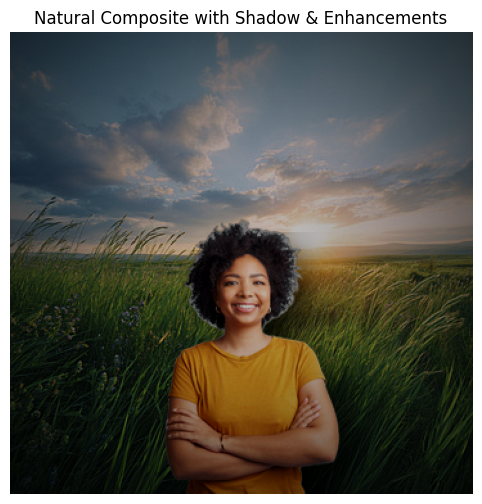

In [38]:
from rembg import remove
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import cv2
import io

def composite_with_shadow_and_enhance(person_path, bg_path, output_path="final_output.jpg"):
    # === Step 1: Remove Background ===
    with open(person_path, 'rb') as i:
        input_data = i.read()
        output_data = remove(input_data)

    person = Image.open(io.BytesIO(output_data)).convert("RGBA")

    # === Step 2: Load Background ===
    bg = Image.open(bg_path).convert("RGBA")
    bg_width, bg_height = bg.size

    # === Step 3: Resize Person ===
    p_width, p_height = person.size
    target_h = int(bg_height * 0.6)
    scale = target_h / p_height
    person = person.resize((int(p_width * scale), target_h), Image.LANCZOS)

    # === Step 4: Slight Brightness Adjust to Match Scene ===
    person = ImageEnhance.Brightness(person).enhance(0.98)

    # === Step 5: Create Soft Shadow ===
    alpha = person.split()[3]
    shadow = Image.new("RGBA", person.size, (0, 0, 0, 120))
    shadow.putalpha(alpha)
    blur_radius = int(person.height * 0.08)
    shadow = shadow.filter(ImageFilter.GaussianBlur(blur_radius))

    # === Step 6: Position Person and Shadow ===
    offset_x = int(person.width * 0.06)
    offset_y = int(person.height * 0.06)
    px = (bg_width - person.width) // 2
    py = bg_height - person.height

    temp_layer = Image.new("RGBA", bg.size, (0, 0, 0, 0))
    temp_layer.paste(shadow, (px + offset_x, py + offset_y), shadow)
    temp_layer.paste(person, (px, py), person)

    # === Step 7: Composite Foreground + Background ===
    composite = Image.alpha_composite(bg, temp_layer)

    # === Step 8: Enhance Naturally ===
    comp_rgb = composite.convert("RGB")
    img_np = np.array(comp_rgb)

    # === Highlights/Shadows via Soft Gamma ===
    def adjust_gamma(img, gamma=0.95):
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
        return cv2.LUT(img, table)

    img_np = adjust_gamma(img_np)

    # === Subtle Enhancements ===
    img_pil = Image.fromarray(img_np)
    img_pil = ImageEnhance.Contrast(img_pil).enhance(1.02)
    img_pil = ImageEnhance.Brightness(img_pil).enhance(1.02)
    img_pil = ImageEnhance.Color(img_pil).enhance(1.05)
    img_pil = ImageEnhance.Sharpness(img_pil).enhance(1.1)
    # (Removed harsh edge enhancement)

    # === Soft Vignette ===
    img_np = np.array(img_pil)
    rows, cols = img_np.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols, cols / 2)
    kernel_y = cv2.getGaussianKernel(rows, rows / 2)
    kernel = kernel_y * kernel_x.T
    mask = (255 * kernel / np.linalg.norm(kernel)) * 0.8  # Reduced strength


    vignette = np.zeros_like(img_np)
    for i in range(3):
        vignette[..., i] = img_np[..., i] * mask
    vignette = np.clip(vignette, 0, 255).astype(np.uint8)

    # === Save and Show Final Output ===
    final_image = Image.fromarray(vignette)
    final_image.save(output_path)
    plt.figure(figsize=(12, 6))
    plt.imshow(final_image)
    plt.axis('off')
    plt.title("Natural Composite with Shadow & Enhancements")
    plt.show()

# === Run the Code ===
composite_with_shadow_and_enhance("p1.jpg", "bg.jpg")


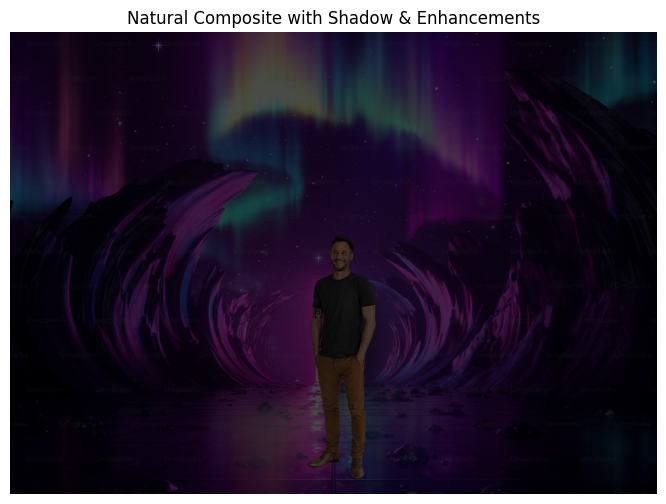

In [42]:
from rembg import remove
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import cv2
import io

def composite_with_shadow_and_enhance(person_path, bg_path, output_path="final_output.jpg"):
    # === Step 1: Remove Background ===
    with open(person_path, 'rb') as i:
        input_data = i.read()
        output_data = remove(input_data)

    person = Image.open(io.BytesIO(output_data)).convert("RGBA")

    # === Step 2: Load Background ===
    bg = Image.open(bg_path).convert("RGBA")
    bg_width, bg_height = bg.size

    # === Step 3: Resize Person ===
    p_width, p_height = person.size
    target_h = int(bg_height * 0.6)
    scale = target_h / p_height
    person = person.resize((int(p_width * scale), target_h), Image.LANCZOS)

    # === Step 4: Slight Brightness Adjust to Match Scene ===
    person = ImageEnhance.Brightness(person).enhance(0.98)

    # === Step 5: Create Soft Shadow ===
    alpha = person.split()[3]
    shadow = Image.new("RGBA", person.size, (0, 0, 0, 120))
    shadow.putalpha(alpha)
    blur_radius = int(person.height * 0.08)
    shadow = shadow.filter(ImageFilter.GaussianBlur(blur_radius))

    # === Step 6: Position Person and Shadow ===
    offset_x = int(person.width * 0.06)
    offset_y = int(person.height * 0.06)
    px = (bg_width - person.width) // 2
    py = bg_height - person.height

    temp_layer = Image.new("RGBA", bg.size, (0, 0, 0, 0))
    temp_layer.paste(shadow, (px + offset_x, py + offset_y), shadow)
    temp_layer.paste(person, (px, py), person)

    # === Step 7: Composite Foreground + Background ===
    composite = Image.alpha_composite(bg, temp_layer)

    # === Step 8: Enhance Naturally ===
    comp_rgb = composite.convert("RGB")
    img_np = np.array(comp_rgb)

    # === Highlights/Shadows via Soft Gamma ===
    def adjust_gamma(img, gamma=0.95):
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
        return cv2.LUT(img, table)

    img_np = adjust_gamma(img_np)

    # === Subtle Enhancements ===
    img_pil = Image.fromarray(img_np)
    img_pil = ImageEnhance.Contrast(img_pil).enhance(1.02)
    img_pil = ImageEnhance.Brightness(img_pil).enhance(1.02)
    img_pil = ImageEnhance.Color(img_pil).enhance(1.05)
    img_pil = ImageEnhance.Sharpness(img_pil).enhance(1.1)
    # (Removed harsh edge enhancement)

    # === Soft Vignette ===
    img_np = np.array(img_pil)
    rows, cols = img_np.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols, cols / 2)
    kernel_y = cv2.getGaussianKernel(rows, rows / 2)
    kernel = kernel_y * kernel_x.T
    mask = (255 * kernel / np.linalg.norm(kernel)) * 0.5  # Reduced strength
    mask = np.clip(mask / 255.0 + 0.3, 0, 1)


    vignette = np.zeros_like(img_np)
    for i in range(3):
        vignette[..., i] = img_np[..., i] * mask
    vignette = np.clip(vignette, 0, 255).astype(np.uint8)

    # === Save and Show Final Output ===
    final_image = Image.fromarray(vignette)
    final_image.save(output_path)
    plt.figure(figsize=(12, 6))
    plt.imshow(final_image)
    plt.axis('off')
    plt.title("Natural Composite with Shadow & Enhancements")
    plt.show()

# === Run the Code ===
composite_with_shadow_and_enhance("p2.jpg", "bg2.jpg")


In [20]:
%%writefile app.py


import streamlit as st
from PIL import Image, ImageEnhance, ImageFilter
from rembg import remove
import numpy as np
import cv2
import io

st.set_page_config(page_title="AI Image Composer", layout="wide")

st.title("🖼️ AI-Based Background Removal + Shadow + Enhancement")

st.sidebar.header("Upload Images")
bg_file = st.sidebar.file_uploader("Background Image", type=["jpg", "png", "jpeg"])
person_file = st.sidebar.file_uploader("Person Image", type=["jpg", "png", "jpeg"])

if bg_file and person_file:
    st.subheader("📤 Original Inputs")
    col1, col2 = st.columns(2)
    with col1:
        st.image(bg_file, caption="Background Image", use_column_width=True)
    with col2:
        st.image(person_file, caption="Person Image", use_column_width=True)

    # === Step 1: Background removal ===
    person_data = person_file.read()
    person_no_bg_data = remove(person_data)
    person_img = Image.open(io.BytesIO(person_no_bg_data)).convert("RGBA")
    bg = Image.open(bg_file).convert("RGBA")

    # === Step 2: Resize and enhance person ===
    bg_w, bg_h = bg.size
    pw, ph = person_img.size
    target_h = int(bg_h * 0.6)
    scale = target_h / ph
    person_resized = person_img.resize((int(pw * scale), target_h), Image.LANCZOS)
    person_resized = ImageEnhance.Brightness(person_resized).enhance(0.98)

    # === Step 3: Shadow ===
    alpha = person_resized.split()[3]
    shadow = Image.new("RGBA", person_resized.size, (0, 0, 0, 150))
    shadow.putalpha(alpha)
    blur_radius = int(person_resized.height * 0.1)
    shadow = shadow.filter(ImageFilter.GaussianBlur(blur_radius))

    offset_x = int(person_resized.width * 0.08)
    offset_y = int(person_resized.height * 0.08)
    temp_layer = Image.new("RGBA", bg.size, (0, 0, 0, 0))
    px = (bg_w - person_resized.width) // 2
    py = bg_h - person_resized.height

    temp_layer.paste(shadow, (px + offset_x, py + offset_y), shadow)
    temp_layer.paste(person_resized, (px, py), person_resized)

    # === Step 4: Composite ===
    composite = Image.alpha_composite(bg, temp_layer).convert("RGB")
    img = np.array(composite)

    # === Step 5: Enhancement ===
    composite = ImageEnhance.Brightness(composite).enhance(1.1)
    img = np.array(composite)

    def adjust_gamma(img, gamma=0.9):
        inv_gamma = 1.0 / gamma
        table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
        return cv2.LUT(img, table)

    img = adjust_gamma(img, gamma=0.9)
    composite = Image.fromarray(img)
    composite = ImageEnhance.Contrast(composite).enhance(1.0)
    composite = ImageEnhance.Brightness(composite).enhance(1.05)
    composite = ImageEnhance.Color(composite).enhance(1.3)
    composite = ImageEnhance.Sharpness(composite).enhance(1.5)
    composite = composite.filter(ImageFilter.EDGE_ENHANCE_MORE)

    # === Step 6: Vignette ===
    img = np.array(composite)
    rows, cols = img.shape[:2]
    kernel_x = cv2.getGaussianKernel(cols, cols / 2)
    kernel_y = cv2.getGaussianKernel(rows, rows / 2)
    kernel = kernel_y * kernel_x.T
    mask = kernel / np.max(kernel)  # normalize to 0-1
    mask = 0.5 + 0.5 * mask  # scale to range 0.5–1.0 for softer effect

    vignette = np.zeros_like(img, dtype=np.float32)
    for i in range(3):
        vignette[..., i] = img[..., i] * mask

    vignette = np.clip(vignette, 0, 255).astype(np.uint8)
    final_image = Image.fromarray(vignette)

    # === Step 7: Display Output ===
    st.subheader("🎨 Final Output")
    st.image(final_image, use_column_width=True)

    # === Step 8: Download ===
    img_bytes = io.BytesIO()
    final_image.save(img_bytes, format="JPEG")
    st.download_button("📥 Download Final Image", img_bytes.getvalue(), file_name="composite_final.jpg", mime="image/jpeg")

else:
    st.info("Upload both a background and a person image to begin.")


Overwriting app.py
